In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading in data 
adj =  np.genfromtxt('Inputs/adj.csv', delimiter=',', dtype=np.int8)
data = np.genfromtxt('Inputs/data.csv', delimiter=',')

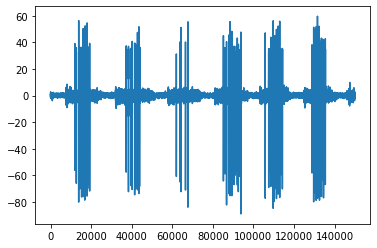

In [3]:
# Plotting the first channel 
plt.plot(data[:,1])
plt.show()

In [4]:
# Figuring out how to generate dummy data

# Sinusodal data
def gen_dummy_data():
    # TODO: Paramterize this so it can change size, perhaps function o_O
    return np.asarray([np.sin(np.arange(0,100,.1))]*16).transpose()
    
def gen_dummy_adj():
    # TODO: No clue, this is hard coded
    tmp = []
    for i in range(1,16,2):
        tmp.append([i-1, i])
        tmp.append([i, i-1])
    return np.asarray(tmp)


In [5]:
# Generating dummy data with unique spike templates 

# Generating spike times 
def gen_spike_times(numSpks, lim, numTemplates, numChans):
    """numSpks: # of spikes, lim: length of data, numTemplates: # of templates, numChans: # of channels"""
    spkTimes = []
    spkChans = []
    for i in range(numTemplates):
        spkTimes.append(np.random.choice(range(lim), numSpks, replace = False))
        spkChans.append(np.random.choice(range(numChans), numSpks, replace=True))
    return np.asarray(spkTimes), np.asarray(spkChans)

# Generating spike template
def gen_spike_templates(numSpks,muWidth=90,sigmaWidth=10, muFac=0.1, sigmaFac=0.02, muVert=200, sigmaVert=40):
    """
    numSpks: # of Spikes, muWidth: mean width of spike, sigmaWidth: stdev of spike width, muFac: mean width fator, 
    sigmaFac: stdev of spike factor, muVert: mean vertical scaling factor, sigmaVert: stdev of vertical scaling factor
    """
    from scipy import signal 
    
    waveforms = []
    
    for i in range(numSpks):
        width = sigmaWidth * np.random.randn() + muWidth 
        factor = (np.abs(sigmaFac*np.random.randn()+muFac))*width
        polarity = np.random.choice([1,-1], 1)[0]
        vertical = sigmaVert*np.random.randn()+muVert
        # Add a linear equations on top | super impose multiple rickers
        waveforms.append(polarity*signal.ricker(width, factor)*vertical)
    return np.asarray(waveforms, dtype=object)

In [6]:
# Plotting of waveforms 
def plot_waveforms(wave):
    fig, axs = plt.subplots(4,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.grid=True
    
    # Loop variables 
    count, minY, maxY = 0, float('inf'), -float('inf') 
    
    for i in range(4):
        for j in range(4):
            axs[i][j].plot(wave[count])
            minY = min(min(wave[count]),minY)
            maxY = max(max(wave[count]),maxY)
            count += 1
    
    # Updating Y scale 
    for i in range(4):
        for j in range(4):
            axs[i][j].set_ylim((minY-1, maxY+1))
    
    plt.show()
    return fig, axs

In [7]:
# Generating dummy data set with cool hats 
def generate_hat_data(numSpks, lim, numTemplates, numChans, muWidth=90, sigmaWidth=10, muFac=0.1, sigmaFac=0.02, muVert=25, sigmaVert=5, seed = False):
    if seed:
        np.random.seed(1738)
    
    times, chans = gen_spike_times(numSpks, lim, numTemplates, numChans)
    
    waveforms = gen_spike_templates(numTemplates, muWidth, sigmaWidth, muFac, sigmaFac, muVert, sigmaVert)
    
    # Generating zeros matrix 
    tmp = np.zeros((numChans, lim))
    spikes_inserted = []
    
    for i in range(numTemplates):
        for j in range(numSpks):
            wave = waveforms[i]
            spkTime = times[i][j]
            spkChan = chans[i][j]
            radius = wave.shape[0]//2
            if spkTime - radius > 0 and spkTime + radius + 1 < lim: 
                if wave.shape[0] % 2 == 0:
                    tmp[spkChan][spkTime-radius:spkTime+radius] += wave
                else:
                    tmp[spkChan][spkTime-radius:spkTime+radius+1] += wave
                
                spikes_inserted.append([i,spkTime,spkChan])
    return tmp, np.asarray(spikes_inserted)
            

def insert_spike():
    pass

dummy_data, dummy_spikes = generate_hat_data(10, 1000, 10, 16, seed=True)

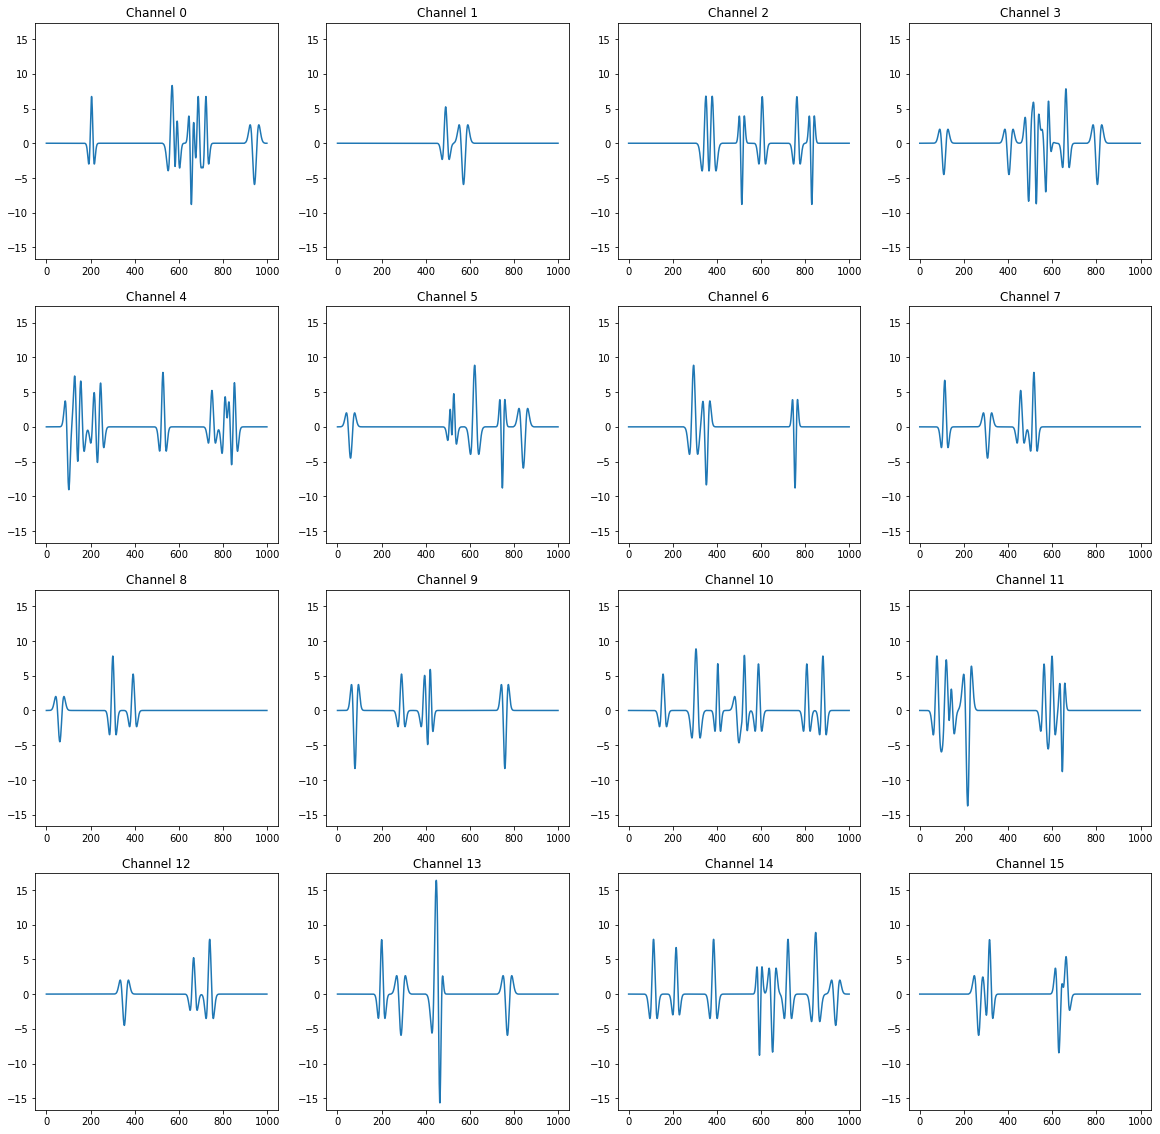

In [8]:
def plot_dummy_data(data):
    fig, axs = plt.subplots(4,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.grid=True
    
    # Loop variables 
    count, minY, maxY = 0, float('inf'), -float('inf') 
    
    for i in range(4):
        for j in range(4):
            axs[i][j].plot(data[count])
            axs[i][j].set_title("Channel {}".format(count))
            minY = min(min(data[count]),minY)
            maxY = max(max(data[count]),maxY)
            count+= 1 
    
    # Updating Y scale 
    for i in range(4):
        for j in range(4):
            axs[i][j].set_ylim((minY-1, maxY+1))
    
    plt.show()
    return fig, axs
a,b = plot_dummy_data(dummy_data)

In [9]:
"""
NOTE: Hard coding for {(0,1), (2,3) ...} adjacency matrix
Psuedo code for new synthetic data creation

# PARAMS
* # of channels, # of templates per channel, # of spikes per template
* Decay factor, offset factor
* Waveform factors: spkHeight, spkWidth 

# SETUP STEPS
* Create empty array (num samples x num channels)

# GENERATE WAVEFORMS 
* params: # of channels, # of templates, # of spikes per template
* opt params: decay factor, offset factor, waveform factors (spkHeight, spkWidth, etc.)
* Generate waveforms, store in np array of (voltage x width x # of templates)

# GENERATE SPIKETIMES
* Go through each waveform, assign it randomly to a channel 
* Extract it's adjacent channel, create a lead,follow channel pair
* Create a set of spike times for the lead channel, use offset param to shift it for follow channel
* Create this as a np array of (channel x # templates) [i,j] = lead / follow times
* Create an array (channel x # templates) [i,j] = scaling factor for template on specific channel
* Do this for each waveform, and have an np array of the above called spk times

# GENERATING DATA
* Iterate through each of the templates, pull out waveform, channel, spk times 
* Inject the appropriate spike into specified channel with specified decay factor
* Repeat for all waveforms
* Add gaussian noise across all channels (parametrize this) 

return data, spk times

"""
print('')

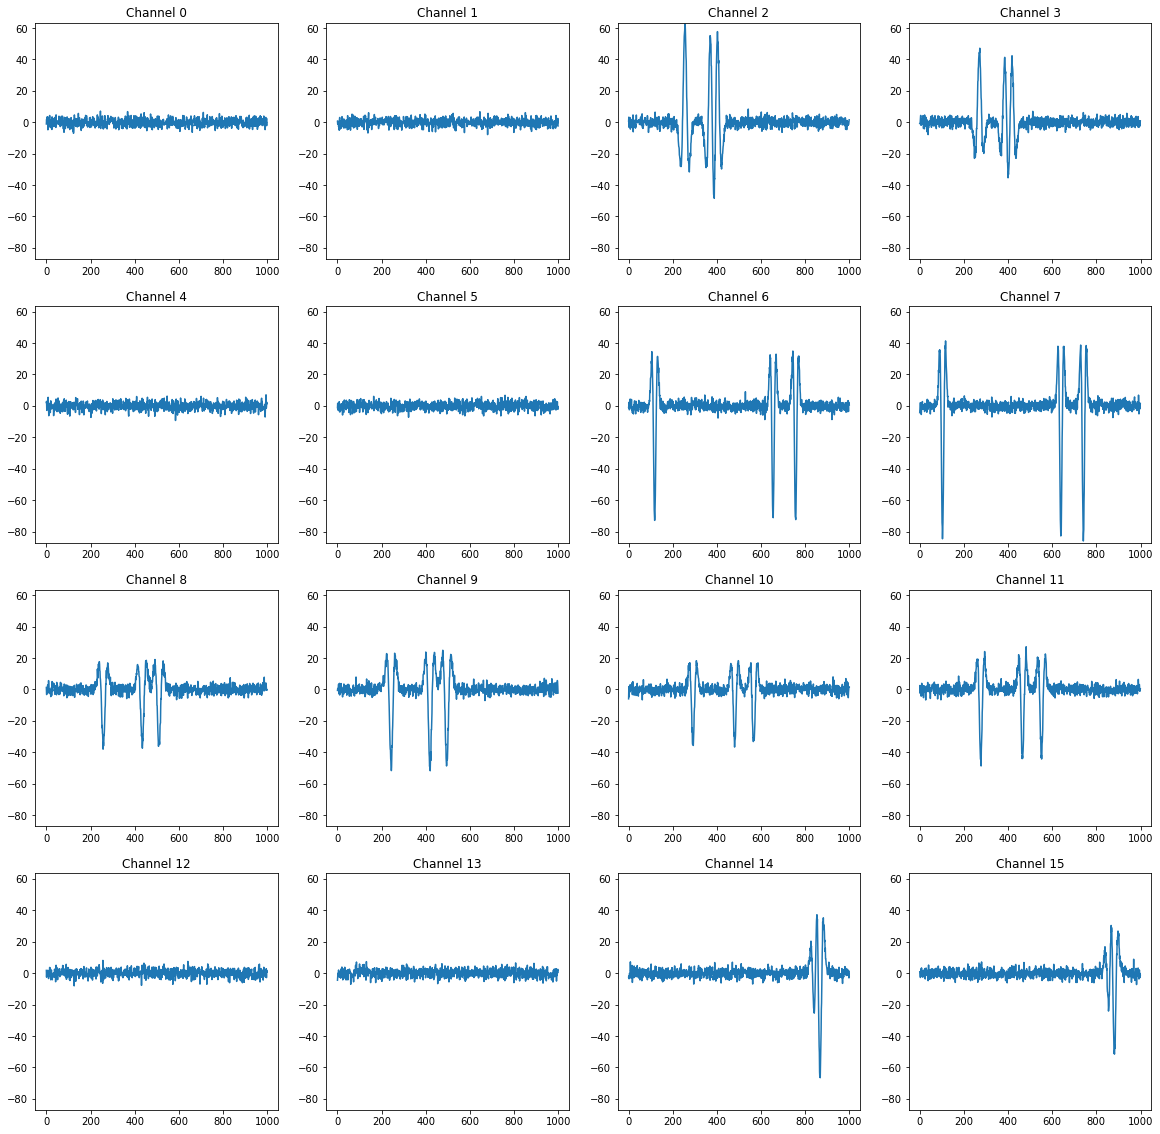

In [48]:
def gen_rel_data(N, nChans, nSpks, nTemplates, offsetMu = 15, offsetSig = 0, decayMu = 0.8, decaySig = 0.05, noiseMu = 0, noiseSig = 1, seed=False, noise=True):
    if seed:
        np.random.seed(1738)
    
    # Setup Steps
    data = np.zeros(shape=(nChans, N))
    
    # Generate Waveforms 
    waveforms = gen_spike_templates(nTemplates)
    
    # Generate Spiketimes 
    # Creating lead - follow pairs
    chanAssign = []
    for i in range(nTemplates):
        chanAssign.append(np.random.choice(range(nChans), replace=False))
        
    chans = []
    for x in chanAssign:
        if x % 2 == 0:
            follow = x + 1
        else:
            follow = x - 1
        chans.append((x, follow))
        
    # Assigning times to those pairs
    times = []
    for pair in chans:
        lead = pair[0]
        follow = pair[1]
        leadTimes = np.random.choice(range(100, N-100), nSpks, replace = False)
        offset = int(offsetSig*np.random.randn()+offsetMu)
        followTimes = leadTimes + offset
        times.append((leadTimes, followTimes))
    
    # Generating Data
    for i in range(nTemplates): 
        wave = waveforms[i]
        radius = wave.shape[0] // 2
        leadChan = chans[i][0]
        followChan = chans[i][1]
        # Lead
        leadTimes = times[i][0]
        for t in leadTimes:
            if wave.shape[0] % 2 == 0:
                data[leadChan][t-radius:t+radius] += wave
            else:
                data[leadChan][t-radius:t+radius+1] += wave
        # Follow
        followTimes = times[i][1]
        decay = decaySig*np.random.randn() + decayMu
        for t in followTimes:
            if wave.shape[0] % 2 == 0:
                data[followChan][t-radius:t+radius] += wave*decay
            else:
                data[followChan][t-radius:t+radius+1] += wave*decay
        
        if noise:
            for channel in data:
                channel += noiseSig*np.random.randn(1000,) + noiseMu
    return data
bruh = gen_rel_data(1000, 16, 3, 5,seed=True)
fig = plot_dummy_data(bruh)

/Users/samir/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(<Figure size 1440x1440 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'Channel 0'}>,
         <AxesSubplot:title={'center':'Channel 1'}>,
         <AxesSubplot:title={'center':'Channel 2'}>,
         <AxesSubplot:title={'center':'Channel 3'}>],
        [<AxesSubplot:title={'center':'Channel 4'}>,
         <AxesSubplot:title={'center':'Channel 5'}>,
         <AxesSubplot:title={'center':'Channel 6'}>,
         <AxesSubplot:title={'center':'Channel 7'}>],
        [<AxesSubplot:title={'center':'Channel 8'}>,
         <AxesSubplot:title={'center':'Channel 9'}>,
         <AxesSubplot:title={'center':'Channel 10'}>,
         <AxesSubplot:title={'center':'Channel 11'}>],
        [<AxesSubplot:title={'center':'Channel 12'}>,
         <AxesSubplot:title={'center':'Channel 13'}>,
         <AxesSubplot:title={'center':'Channel 14'}>,
         <AxesSubplot:title={'center':'Channel 15'}>]], dtype=object))

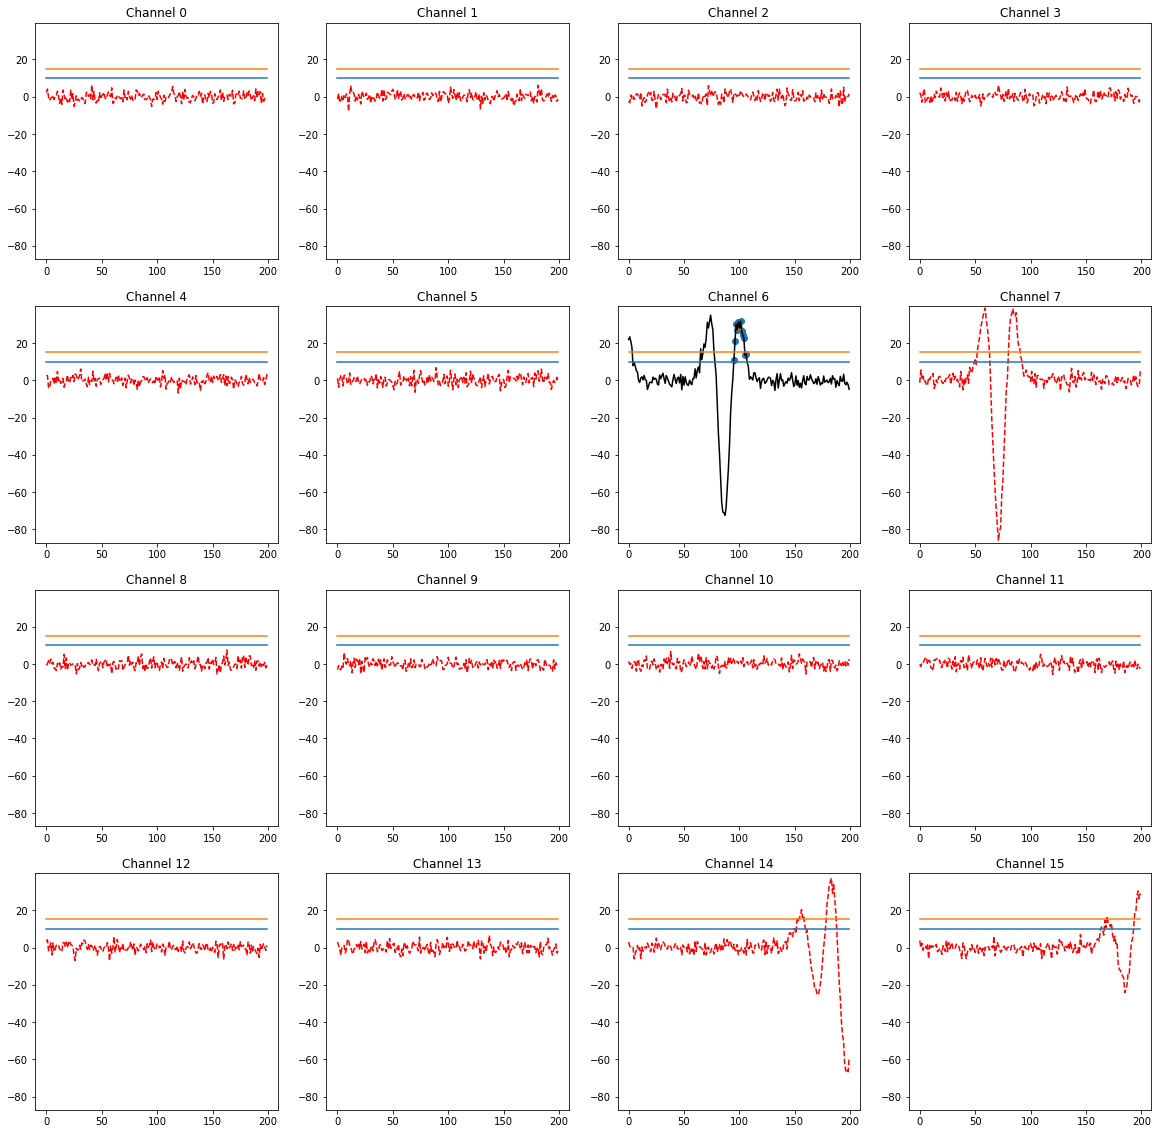

In [58]:
from flood import * 
# offsetMu = [15,20], offsetSig = 0, decayMu = 0.8, decaySig = 0.05, noiseMu = 0, noiseSig = 1
# Floodfill pre range check breaks at this point on inverted hat waveforms ^ 
ff = FloodFill(bruh.transpose(), gen_dummy_adj(), )
ff.detect_spikes(weakMul = 4, strongMul = 6)
ff.plotSpk(8)